In [175]:
import pandas as pd
import numpy as np
import math
import calendar
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
store_calendar = pd.read_csv("Calendar_with_cycled_days.csv", index_col = 0)
date_converter = dict(zip(store_calendar['d'], store_calendar.index))

sell_prices = pd.read_csv("sell_prices_afcs2021.csv", index_col=0)

sample_submission = pd.read_csv("sample_submission_afcs2021.csv", index_col=0)

train_data = pd.read_csv("sales_train_validation_afcs2021.csv", index_col=0)
test_data = pd.read_csv("sales_test_validation_afcs2021.csv", index_col=0)
train_data = train_data.rename(columns=date_converter)
test_data = test_data.rename(columns=date_converter)

total_sales = train_data.sum()


# Attempt at forecasting

In [47]:
big_train = train_data.merge(test_data, left_index=True, right_index=True)
big_train

,1/29/2011,1/30/2011,1/31/2011,2/1/2011,2/2/2011,2/3/2011,2/4/2011,2/5/2011,2/6/2011,2/7/2011,...,5/13/2016,5/14/2016,5/15/2016,5/16/2016,5/17/2016,5/18/2016,5/19/2016,5/20/2016,5/21/2016,5/22/2016
id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_001_TX_3_validation,0,2,1,3,0,0,1,0,2,1,...,1,0,0,0,0,0,0,0,1,0
FOODS_3_002_TX_3_validation,0,0,0,0,0,0,0,0,0,0,...,2,0,0,2,1,0,3,1,1,1
FOODS_3_003_TX_3_validation,0,0,0,0,0,0,0,0,0,0,...,2,0,2,1,0,2,0,0,2,1
FOODS_3_004_TX_3_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
FOODS_3_005_TX_3_validation,0,1,1,0,0,1,2,0,0,1,...,1,0,1,1,1,2,4,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_TX_3_validation,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,1,0,1
FOODS_3_824_TX_3_validation,0,1,0,1,0,2,0,1,1,0,...,0,0,2,1,0,1,0,2,0,0
FOODS_3_825_TX_3_validation,0,0,0,2,1,1,0,0,1,1,...,3,1,1,2,0,2,5,0,0,3


In [51]:
# Preprocess the train data
ts_train_data = big_train.transpose()
ts_train_data.index = pd.to_datetime(ts_train_data.index)
products = list(ts_train_data.columns.values)
originals = list(ts_train_data.columns.values)

for i in products:
    p_name = "_".join(i.split("_")[:3])
    ts_train_data = ts_train_data.rename(columns = {i : p_name})

ts_train_data.index.name = 'date'
ts_train_data

id,FOODS_3_001,FOODS_3_002,FOODS_3_003,FOODS_3_004,FOODS_3_005,FOODS_3_006,FOODS_3_007,FOODS_3_008,FOODS_3_009,FOODS_3_010,...,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,27,0,0,0,...,0,9,3,0,7,0,0,0,0,0
2011-01-30,2,0,0,0,1,0,27,0,0,0,...,0,0,2,0,5,0,1,0,0,0
2011-01-31,1,0,0,0,1,0,8,0,0,0,...,0,3,1,0,5,0,0,0,0,0
2011-02-01,3,0,0,0,0,0,0,0,0,0,...,0,0,3,0,3,0,1,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,0,0,2,0,2,0,0,14,1,0,...,3,0,0,1,0,0,1,2,2,1
2016-05-19,0,3,0,0,4,1,7,18,0,0,...,1,0,0,0,1,1,0,5,4,0
2016-05-20,0,1,0,0,2,2,6,29,0,0,...,2,0,2,1,3,1,2,0,0,4


In [49]:
# Reset index for merging
store_calendar = store_calendar.reset_index()

In [50]:
events = store_calendar['event_name_1']
events_tf = np.zeros(len(events))

for i in range(len(events)):
    if isinstance(events[i], str):
        events_tf[i] = 1

events_tf = [int(item) for item in events_tf]
        
store_calendar['is_event'] = events_tf
store_calendar

,index,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sin_wday,cos_wday,sin_month,cos_month,is_event
0,0,1/29/2011,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,7.818315e-01,0.623490,5.000000e-01,0.866025,0
1,1,1/30/2011,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,9.749279e-01,-0.222521,5.000000e-01,0.866025,0
2,2,1/31/2011,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,4.338837e-01,-0.900969,5.000000e-01,0.866025,0
3,3,2/1/2011,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,-4.338837e-01,-0.900969,8.660254e-01,0.500000,0
4,4,2/2/2011,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,-9.749279e-01,-0.222521,8.660254e-01,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,1964,6/15/2016,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,-9.749279e-01,-0.222521,1.224647e-16,-1.000000,0
1965,1965,6/16/2016,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,-7.818315e-01,0.623490,1.224647e-16,-1.000000,0
1966,1966,6/17/2016,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,-2.449294e-16,1.000000,1.224647e-16,-1.000000,0
1967,1967,6/18/2016,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,7.818315e-01,0.623490,1.224647e-16,-1.000000,0


In [105]:
events = store_calendar['event_name_1']
unique_events = events.unique()[1:]
unique_events

for i in unique_events:
    arr = np.zeros(len(events))
    for j in range(len(events)):
        if events[j] == i:
            arr[j] = 1
    store_calendar[i] = [int(item) for item in arr]

store_calendar.columns.values[18:]
# ts_train_data.columns

array(['SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [160]:
# Merge the calendar and sell_price dataframes
new = pd.merge(sell_prices, store_calendar, on='wm_yr_wk')
new = new.set_index('date')
new.index = pd.to_datetime(new.index)
new

,item_id,wm_yr_wk,sell_price,index,weekday,wday,month,year,d,event_name_1,...,Halloween,EidAlAdha,VeteransDay,Thanksgiving,Christmas,Chanukah End,NewYear,OrthodoxChristmas,MartinLutherKingDay,Easter
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,FOODS_3_001,11101,2.28,0,Saturday,1,1,2011,d_1,NaN,...,0,0,0,0,0,0,0,0,0,0
2011-01-30,FOODS_3_001,11101,2.28,1,Sunday,2,1,2011,d_2,NaN,...,0,0,0,0,0,0,0,0,0,0
2011-01-31,FOODS_3_001,11101,2.28,2,Monday,3,1,2011,d_3,NaN,...,0,0,0,0,0,0,0,0,0,0
2011-02-01,FOODS_3_001,11101,2.28,3,Tuesday,4,2,2011,d_4,NaN,...,0,0,0,0,0,0,0,0,0,0
2011-02-02,FOODS_3_001,11101,2.28,4,Wednesday,5,2,2011,d_5,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-19,FOODS_3_825,11621,3.98,1968,Sunday,2,6,2016,d_1969,NBAFinalsEnd,...,0,0,0,0,0,0,0,0,0,0
2016-06-18,FOODS_3_826,11621,1.28,1967,Saturday,1,6,2016,d_1968,NaN,...,0,0,0,0,0,0,0,0,0,0
2016-06-19,FOODS_3_826,11621,1.28,1968,Sunday,2,6,2016,d_1969,NBAFinalsEnd,...,0,0,0,0,0,0,0,0,0,0


In [161]:
# Add noise to the sell price so it can be added to the VAR model (variables can't be constant)
original = new['sell_price']
noise = np.random.normal(.01, .001, len(new))
new['sell_price'] = new['sell_price'] + noise
new

,item_id,wm_yr_wk,sell_price,index,weekday,wday,month,year,d,event_name_1,...,Halloween,EidAlAdha,VeteransDay,Thanksgiving,Christmas,Chanukah End,NewYear,OrthodoxChristmas,MartinLutherKingDay,Easter
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,FOODS_3_001,11101,2.289260,0,Saturday,1,1,2011,d_1,NaN,...,0,0,0,0,0,0,0,0,0,0
2011-01-30,FOODS_3_001,11101,2.289004,1,Sunday,2,1,2011,d_2,NaN,...,0,0,0,0,0,0,0,0,0,0
2011-01-31,FOODS_3_001,11101,2.290598,2,Monday,3,1,2011,d_3,NaN,...,0,0,0,0,0,0,0,0,0,0
2011-02-01,FOODS_3_001,11101,2.289681,3,Tuesday,4,2,2011,d_4,NaN,...,0,0,0,0,0,0,0,0,0,0
2011-02-02,FOODS_3_001,11101,2.289576,4,Wednesday,5,2,2011,d_5,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-19,FOODS_3_825,11621,3.990624,1968,Sunday,2,6,2016,d_1969,NBAFinalsEnd,...,0,0,0,0,0,0,0,0,0,0
2016-06-18,FOODS_3_826,11621,1.288120,1967,Saturday,1,6,2016,d_1968,NaN,...,0,0,0,0,0,0,0,0,0,0
2016-06-19,FOODS_3_826,11621,1.288460,1968,Sunday,2,6,2016,d_1969,NBAFinalsEnd,...,0,0,0,0,0,0,0,0,0,0


In [153]:
var_list = [['sin_wday', 'cos_wday', 'sell_price', 'is_event']]
events = store_calendar.columns.values[18:]
var_list.append(list(events))
var_list = [item for sublist in var_list for item in sublist]
var_list

['sin_wday',
 'cos_wday',
 'sell_price',
 'is_event',
 'SuperBowl',
 'ValentinesDay',
 'PresidentsDay',
 'LentStart',
 'LentWeek2',
 'StPatricksDay',
 'Purim End',
 'OrthodoxEaster',
 'Pesach End',
 'Cinco De Mayo',
 "Mother's day",
 'MemorialDay',
 'NBAFinalsStart',
 'NBAFinalsEnd',
 "Father's day",
 'IndependenceDay',
 'Ramadan starts',
 'Eid al-Fitr',
 'LaborDay',
 'ColumbusDay',
 'Halloween',
 'EidAlAdha',
 'VeteransDay',
 'Thanksgiving',
 'Christmas',
 'Chanukah End',
 'NewYear',
 'OrthodoxChristmas',
 'MartinLutherKingDay',
 'Easter']

In [229]:
# Code in this cell from: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


df_train = ts_train_data[products[0]]
df_sales = new[new['item_id'] == products[0]]
dftest = pd.merge(df_sales, df_train, on="date")[[products[0], 'is_event', 'sin_month', 'cos_month', 'sell_price']]
print(dftest)

grangers_causation_matrix(dftest, variables = dftest.columns)

            FOODS_3_001  is_event  sin_month  cos_month  sell_price
date                                                               
2011-01-29            0         0   0.500000   0.866025    2.289260
2011-01-30            2         0   0.500000   0.866025    2.289004
2011-01-31            1         0   0.500000   0.866025    2.290598
2011-02-01            3         0   0.866025   0.500000    2.289681
2011-02-02            0         0   0.866025   0.500000    2.289576
...                 ...       ...        ...        ...         ...
2016-05-18            0         0   0.500000  -0.866025    2.509043
2016-05-19            0         0   0.500000  -0.866025    2.510151
2016-05-20            0         0   0.500000  -0.866025    2.509860
2016-05-21            1         0   0.500000  -0.866025    2.511505
2016-05-22            0         0   0.500000  -0.866025    2.511081

[1941 rows x 5 columns]


C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,FOODS_3_001_x,is_event_x,sin_month_x,cos_month_x,sell_price_x
FOODS_3_001_y,1.0000,0.4139,0.1764,0.0057,0.0000
is_event_y,0.6277,1.0000,0.0000,0.0007,0.0121
sin_month_y,0.1444,0.0483,1.0000,0.0000,0.0070
cos_month_y,0.1499,0.0000,0.0000,1.0000,0.0025
sell_price_y,0.0000,0.0000,0.0203,0.0423,1.0000


In [246]:
# Code in this cell from: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


def adjust(val, length= 6): 
    return str(val).ljust(length)

cointegration_test(dftest)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
FOODS_3_001 ::  717.47    > 60.0627   =>   True
is_event ::  348.12    > 40.1749   =>   True
sin_month ::  154.19    > 24.2761   =>   True
cos_month ::  75.48     > 12.3212   =>   True
sell_price ::  0.6       > 4.1296    =>   False


In [232]:
# Code in this cell from: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
        
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "FOODS_3_001" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.0917
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "is_event" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.1093
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sin_month" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significa

In [347]:
# Create the forecasts
def make_forecast(train_data, price, product_names, original_product_names):
    submission = []
    
    for i in range(len(product_names)):
        df_train = train_data[product_names[i]]
        df_sales = price[price['item_id'] == product_names[i]]
        df = pd.merge(df_sales, df_train, on="date")[[product_names[i], 'sin_month', 'cos_month', 'sin_wday', 'cos_wday', 'is_event', 'sell_price']] #, 'SuperBowl', 
#                                                       'ValentinesDay', 'PresidentsDay', 'LentStart', 'LentWeek2', 
#                                                       'StPatricksDay', 'Purim End', 'OrthodoxEaster', 'Pesach End', 
#                                                       'Cinco De Mayo', "Mother's day", 'MemorialDay', 'NBAFinalsStart', 
#                                                       'NBAFinalsEnd', "Father's day", 'IndependenceDay', 'Ramadan starts', 
#                                                       'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 'Halloween', 'EidAlAdha', 
#                                                       'VeteransDay', 'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear', 
#                                                       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter']]
        

#         Uncomment to make the data stationary
#         df = df.diff().dropna()
        
        model = VAR(df)
        model_fit = model.fit(maxlags=15, ic='bic')
        
#         Uncomment this to calculate the Durbin Watson statistic
#         out = durbin_watson(model_fit.resid)
#         for col, val in zip(df.columns, out):
#             print(adjust(col), ':', round(val, 2))
            
        prediction = model_fit.forecast(model_fit.y, steps=28)
        
#         Uncomment to de-difference the predictions
#         df_forecast = pd.DataFrame(prediction, columns=df.columns + '_2d')
#         df_fc = df_forecast.copy()
#         columns = df.columns
#         for col in columns: 
#             df_fc[str(col)+'_forecast'] = df[col].iloc[-1] + df_fc[str(col)+'_2d'].cumsum()

#         fc = df_fc[product_names[i]+'_forecast'].values.tolist()
        
        fc = prediction[:,0].tolist()
        fc.insert(0, originals[i])
        submission.append(fc)

    return submission
 
products = list(ts_train_data.columns.values)
df = make_forecast(ts_train_data, new, products, originals)

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\lotte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

In [348]:
# Convert forecasts to a dataframe
df = pd.DataFrame(df, columns=['id','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20','F21','F22','F23','F24','F25','F26','F27','F28'])
df = df.set_index('id')
df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_001_TX_3_validation,0.240873,0.204750,0.166972,0.160631,0.206256,0.302652,0.280882,0.305967,0.293123,0.241999,...,0.227230,0.266231,0.304657,0.313136,0.284202,0.238691,0.210584,0.220468,0.260679,0.300724
FOODS_3_002_TX_3_validation,0.786636,0.603502,0.419624,0.343733,0.426919,0.606832,0.749865,0.750560,0.610715,0.437950,...,0.468018,0.647591,0.790158,0.790367,0.650040,0.476806,0.403052,0.486237,0.665620,0.808004
FOODS_3_003_TX_3_validation,0.924709,0.874669,0.826626,0.812178,0.843318,0.898521,0.937892,0.933052,0.888508,0.838299,...,0.836859,0.887449,0.922646,0.914023,0.866043,0.812704,0.791942,0.817075,0.866775,0.901138
FOODS_3_004_TX_3_validation,0.175795,0.162953,0.157548,0.165175,0.179734,0.189931,0.187757,0.174519,0.159852,0.154468,...,0.173495,0.183681,0.181499,0.168253,0.153581,0.148194,0.155810,0.170359,0.180549,0.178371
FOODS_3_005_TX_3_validation,1.263248,1.124968,0.734247,0.655928,0.654704,0.714943,0.734156,0.682387,0.585223,0.510533,...,0.593869,0.686464,0.727063,0.685998,0.595088,0.523678,0.526418,0.602112,0.694618,0.735123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_TX_3_validation,0.387614,0.370176,0.394968,0.435166,0.431567,0.470428,0.489793,0.395913,0.368828,0.356435,...,0.320014,0.332085,0.332516,0.313226,0.286384,0.273070,0.277565,0.297142,0.315385,0.315605
FOODS_3_824_TX_3_validation,0.601672,0.522479,0.420644,0.450106,0.526256,0.626585,0.498137,0.451291,0.452614,0.431846,...,0.478208,0.504276,0.495636,0.456813,0.416469,0.404840,0.429780,0.471516,0.498179,0.488995
FOODS_3_825_TX_3_validation,1.441630,1.332220,1.091154,0.971528,1.156162,1.152452,1.122103,1.094047,0.947506,0.828013,...,0.775898,0.876543,0.925804,0.880945,0.772702,0.677781,0.664827,0.740364,0.844381,0.896305


In [349]:
# Calculate the RMSE
np.sqrt(mean_squared_error(df, test_data))

3.393338101386708

# Results

In [195]:
# Save the best RMSE for comparison
best = df
np.sqrt(mean_squared_error(best, test_data))

3.0676209131204337

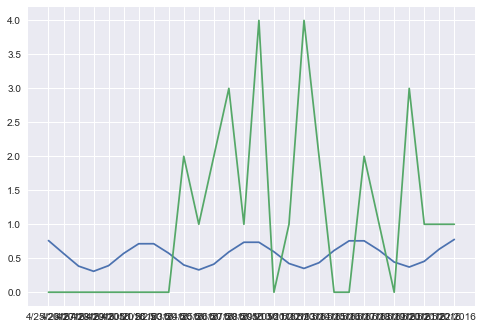

In [350]:
# Plot the actuals vs the forecasts of the first product in the dataset
plt.style.use('seaborn')
df1 = best.iloc[1]
df1.index = test_data.iloc[0].index
plt.plot(df1)
plt.plot(test_data.iloc[1])
plt.show()

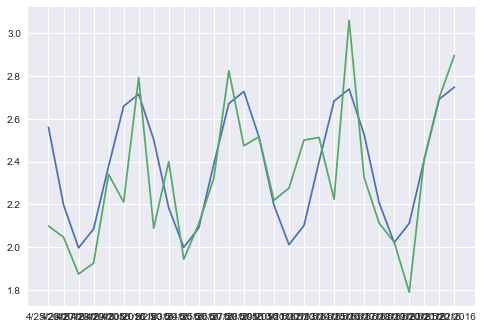

In [351]:
# Plot the actuals vs the forecasts of the average of all the products in the dataset
summed = df.sum(axis=0)/823
summed.index = test_data.iloc[0].index

plt.plot(summed)
plt.plot(test_data.sum(axis=0)/823)
plt.show()

# Make CSV file

In [196]:
# Create the CSV file
sub = df.reset_index()
sub.to_csv("submission.csv", index=False)